<a href="https://colab.research.google.com/github/hrnnikolov/ML_models/blob/main/cnn/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Convert Mnist files into a tensor of 4- dimentions
transform = transforms.ToTensor()

In [3]:
train_data = datasets.MNIST(root='/cnn_data', train=True, download=True, transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 78263698.02it/s]


Extracting /cnn_data/MNIST/raw/train-images-idx3-ubyte.gz to /cnn_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 41118701.23it/s]


Extracting /cnn_data/MNIST/raw/train-labels-idx1-ubyte.gz to /cnn_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 120750975.95it/s]

Extracting /cnn_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /cnn_data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 12683441.26it/s]


Extracting /cnn_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /cnn_data/MNIST/raw



In [4]:
test_data = datasets.MNIST(root='/cnn_data', train=False, download=True, transform=transform)

In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
#batch size - 10
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [8]:
#creating 2 convolutional layers
conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)

In [9]:
#grab 1 MNIST record
for i, (X_train, y_train) in enumerate(train_data):
  break

In [10]:
x = X_train.view(1, 1, 28, 28)

In [11]:
x = F.relu(conv1(x)) #Rectified Linear Unit for our activation function

In [12]:
# pass through the pooling layer
x = F.max_pool2d(x, 2, 2) #kernel of 2 and stride of 2

In [13]:
x.shape

torch.Size([1, 6, 13, 13])

In [15]:
x = F.relu(conv2(x))

RuntimeError: ignored

In [16]:
x.shape

torch.Size([1, 16, 11, 11])

In [17]:
x = F.max_pool2d(x, 2, 2)

In [18]:
x.shape

torch.Size([1, 16, 5, 5])

In [19]:
# Model class
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 6, 3, 1)
    self.conv2 = nn.Conv2d(6, 16, 3, 1)

    # Fully Connected Layer
    self.fc1 = nn.Linear(5*5*16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X, 2, 2)
    # Second pass
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X, 2, 2)

    # Re-View to flatten it out
    X = X.view(-1, 16*5*5) # negative one so that we can vary batch size

    #Fully connecte layers
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X, dim=1)

In [20]:
torch.manual_seed(3)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [21]:
#Loss function optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [26]:
import time
start_time = time.time()

# Create variables to tracks things
epoches = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

#for loop of epochs
for epoch in range(epoches):
  trn_corr = 0
  tst_corr = 0


  #Train
  for b, (X_train, y_train) in enumerate(train_loader):
    b+=1 #strart our bathes at 1
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)

    predicted = torch.max(y_pred.data, 1)[1] # add up the number of correct predictions.
    batch_corr = (predicted == y_train).sum()
    trn_corr += batch_corr

    #Update our params
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #Print out some results
    if b%600 == 0:
      print(f'Epoch: {epoch}, Batch: {b}, Loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)

  #Test
  with torch.no_grad(): # no gradient, so no update of weights and biases
    for b, (X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1] # adding up correct predictions
      tst_corr += (predicted == y_test).sum()

  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)

current_time = time.time()
total = current_time - start_time
print(f'training took: {total/60} minutes!')

Epoch: 0, Batch: 600, Loss: 0.029581736773252487
Epoch: 0, Batch: 1200, Loss: 0.07777050882577896
Epoch: 0, Batch: 1800, Loss: 0.055349789559841156
Epoch: 0, Batch: 2400, Loss: 0.013083030469715595
Epoch: 0, Batch: 3000, Loss: 0.001102156937122345
Epoch: 0, Batch: 3600, Loss: 0.06669739633798599
Epoch: 0, Batch: 4200, Loss: 0.0030523138120770454
Epoch: 0, Batch: 4800, Loss: 0.008786538615822792
Epoch: 0, Batch: 5400, Loss: 0.009058626368641853
Epoch: 0, Batch: 6000, Loss: 0.0012021695729345083
Epoch: 1, Batch: 600, Loss: 0.02737894095480442
Epoch: 1, Batch: 1200, Loss: 0.009350037202239037
Epoch: 1, Batch: 1800, Loss: 0.0008145025931298733
Epoch: 1, Batch: 2400, Loss: 0.2203940600156784
Epoch: 1, Batch: 3000, Loss: 0.001132521079853177
Epoch: 1, Batch: 3600, Loss: 0.007502963300794363
Epoch: 1, Batch: 4200, Loss: 0.000179346272489056
Epoch: 1, Batch: 4800, Loss: 0.0055447835475206375
Epoch: 1, Batch: 5400, Loss: 0.0003499471058603376
Epoch: 1, Batch: 6000, Loss: 0.00039281806675717235


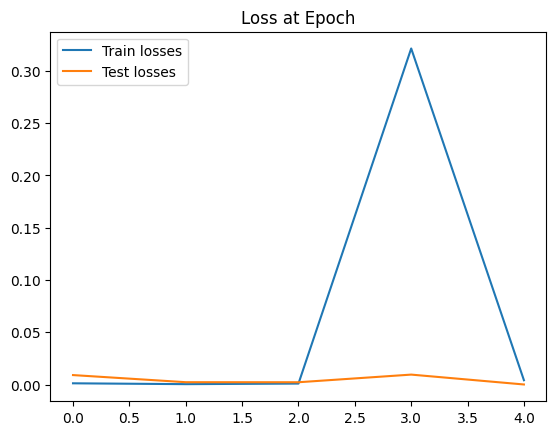

In [29]:
#visualization
train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses, label='Train losses')
plt.plot(test_losses, label='Test losses')
plt.title('Loss at Epoch')
plt.legend()

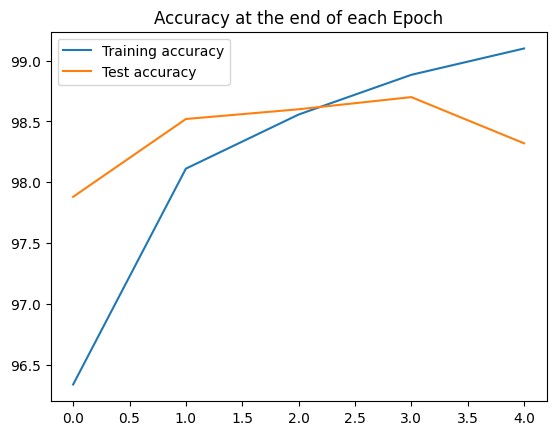

In [31]:
#graph the accuracy
plt.plot([t/600 for t in train_correct], label='Training accuracy')
plt.plot([t/100 for t in test_correct], label='Test accuracy')
plt.title('Accuracy at the end of each Epoch')
plt.legend()

In [32]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)

In [33]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum()

In [39]:
correct.item()/len(test_data)*100

98.32

In [40]:
#grab an image
test_data[3333]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [42]:
#grab just the data
test_data[3333][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

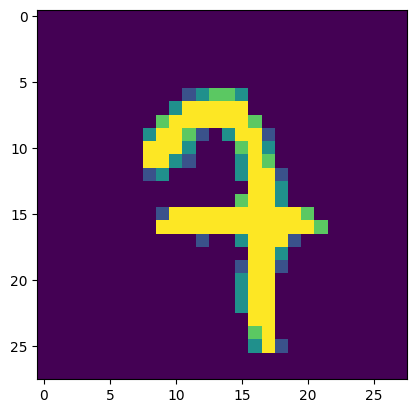

In [43]:
#reshape
plt.imshow(test_data[3333][0].reshape(28,28))

In [44]:
#pass the image thru
model.eval()
with torch.no_grad():
  new_prediction = model(test_data[3333][0].view(1,1,28,28)) #batch size 1 , color channel 1, 28x28 size

In [45]:
new_prediction

tensor([[-16.0642, -10.6026,  -8.9120,  -6.5541,  -4.9708, -10.5986, -18.8228,
          -0.0252, -14.2136,  -4.1154]])

In [46]:
new_prediction.argmax()

tensor(7)